In [40]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

The description of this dataset is contained in the .txt file present in the resources of the exercise.

In [41]:
# Charger et préparer les données
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/R%C3%A9gression+r%C3%A9gularis%C3%A9es/news/OnlineNewsPopularity.csv"
data = pd.read_csv(url).rename(columns=lambda x: x.strip()).sample(1000, random_state=1)

# Afficher les premières lignes
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
27187,http://mashable.com/2014/06/17/peer-to-peer-bu...,205.0,12.0,1349.0,0.339059,1.0,0.425668,51.0,3.0,33.0,...,0.050000,1.0,-0.225513,-0.8,-0.076923,0.475000,0.150000,0.025000,0.150000,5200
2277,http://mashable.com/2013/02/14/nba-stats-data/,693.0,10.0,554.0,0.531760,1.0,0.700880,11.0,7.0,1.0,...,0.033333,1.0,-0.287778,-0.5,-0.155556,0.100000,0.000000,0.400000,0.000000,2300
18309,http://mashable.com/2014/01/04/5-most-negative...,369.0,13.0,751.0,0.427793,1.0,0.578475,12.0,1.0,1.0,...,0.050000,0.6,-0.193155,-0.6,-0.050000,0.382143,0.139286,0.117857,0.139286,3300
15731,http://mashable.com/2013/11/06/mobli-carlos-slim/,428.0,12.0,1207.0,0.478898,1.0,0.664804,29.0,0.0,1.0,...,0.033333,1.0,-0.250309,-0.6,-0.100000,0.500000,0.500000,0.000000,0.500000,2200
11849,http://mashable.com/2013/08/21/mark-malkoff-sk...,505.0,13.0,329.0,0.616564,1.0,0.765000,5.0,2.0,0.0,...,0.136364,0.5,-0.243333,-0.5,-0.050000,0.000000,0.000000,0.500000,0.000000,5200


Take a moment to display data info in order to check for missing values.
    
We won't use the "url" column : you have to drop it. Also just from the variables names we can anticipate that a number of variables will be exactly correlated, remove those variables. Remove also "LDA_00", "rate_positive_words", "n_non_stop_words", that are also near collinear when given a small sample of data.

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 27187 to 25040
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            1000 non-null   object 
 1   timedelta                      1000 non-null   float64
 2   n_tokens_title                 1000 non-null   float64
 3   n_tokens_content               1000 non-null   float64
 4   n_unique_tokens                1000 non-null   float64
 5   n_non_stop_words               1000 non-null   float64
 6   n_non_stop_unique_tokens       1000 non-null   float64
 7   num_hrefs                      1000 non-null   float64
 8   num_self_hrefs                 1000 non-null   float64
 9   num_imgs                       1000 non-null   float64
 10  num_videos                     1000 non-null   float64
 11  average_token_length           1000 non-null   float64
 12  num_keywords                   1000 non-null   f

In [43]:
# Exclusion des features
dataset_filtered = data.drop(["url", "weekday_is_sunday","is_weekend", "LDA_00", "rate_positive_words", "n_non_stop_words"], axis=1)
dataset_filtered.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
27187,205.0,12.0,1349.0,0.339059,0.425668,51.0,3.0,33.0,1.0,4.851742,...,0.050000,1.0,-0.225513,-0.8,-0.076923,0.475000,0.150000,0.025000,0.150000,5200
2277,693.0,10.0,554.0,0.531760,0.700880,11.0,7.0,1.0,0.0,4.722022,...,0.033333,1.0,-0.287778,-0.5,-0.155556,0.100000,0.000000,0.400000,0.000000,2300
18309,369.0,13.0,751.0,0.427793,0.578475,12.0,1.0,1.0,0.0,4.482024,...,0.050000,0.6,-0.193155,-0.6,-0.050000,0.382143,0.139286,0.117857,0.139286,3300
15731,428.0,12.0,1207.0,0.478898,0.664804,29.0,0.0,1.0,0.0,4.706711,...,0.033333,1.0,-0.250309,-0.6,-0.100000,0.500000,0.500000,0.000000,0.500000,2200
11849,505.0,13.0,329.0,0.616564,0.765000,5.0,2.0,0.0,1.0,5.130699,...,0.136364,0.5,-0.243333,-0.5,-0.050000,0.000000,0.000000,0.500000,0.000000,5200


In [44]:
# Affichage du nombre de lignes dans le dataset
print(f"Number of rows: {dataset_filtered.shape[0]}\n")
print(f"Number of columns: {dataset_filtered.shape[1]}\n")

# Affichage des premières lignes du dataset filtré
print("Display of dataset (first 5 rows):")
display(dataset_filtered.head())
print()

# Statistiques descriptives de base pour le dataset
print("Basic statistics: ")
data_desc = dataset_filtered.describe(include='all')
display(data_desc)
print()

# Calcul et affichage du pourcentage de valeurs manquantes par colonne
print("Percentage of missing values per column: ")
missing_values = (100 * dataset_filtered.isnull().sum() / dataset_filtered.shape[0]).round(2)
display(missing_values)

Number of rows: 1000

Number of columns: 55

Display of dataset (first 5 rows):


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
27187,205.0,12.0,1349.0,0.339059,0.425668,51.0,3.0,33.0,1.0,4.851742,...,0.050000,1.0,-0.225513,-0.8,-0.076923,0.475000,0.150000,0.025000,0.150000,5200
2277,693.0,10.0,554.0,0.531760,0.700880,11.0,7.0,1.0,0.0,4.722022,...,0.033333,1.0,-0.287778,-0.5,-0.155556,0.100000,0.000000,0.400000,0.000000,2300
18309,369.0,13.0,751.0,0.427793,0.578475,12.0,1.0,1.0,0.0,4.482024,...,0.050000,0.6,-0.193155,-0.6,-0.050000,0.382143,0.139286,0.117857,0.139286,3300
15731,428.0,12.0,1207.0,0.478898,0.664804,29.0,0.0,1.0,0.0,4.706711,...,0.033333,1.0,-0.250309,-0.6,-0.100000,0.500000,0.500000,0.000000,0.500000,2200
11849,505.0,13.0,329.0,0.616564,0.765000,5.0,2.0,0.0,1.0,5.130699,...,0.136364,0.5,-0.243333,-0.5,-0.050000,0.000000,0.000000,0.500000,0.000000,5200



Basic statistics: 


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,350.293000,10.484000,540.058000,0.533191,0.676836,10.799000,3.19400,4.570000,1.24000,4.567762,...,0.100505,0.764513,-0.254494,-0.510839,-0.102380,0.277957,0.069438,0.353569,0.152021,3445.639000
std,212.748695,2.092396,465.540633,0.129250,0.144861,11.115402,3.39085,8.918556,4.55754,0.767052,...,0.078553,0.239552,0.119911,0.285152,0.083702,0.331816,0.268229,0.185251,0.231603,9484.595919
min,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,43.000000
25%,165.000000,9.000000,241.750000,0.473558,0.630832,4.000000,1.00000,1.000000,0.00000,4.488171,...,0.050000,0.600000,-0.319729,-0.700000,-0.125000,0.000000,0.000000,0.186458,0.000000,924.750000
50%,328.500000,10.000000,408.500000,0.538990,0.692308,7.000000,3.00000,1.000000,0.00000,4.646244,...,0.100000,0.800000,-0.250000,-0.500000,-0.100000,0.066667,0.000000,0.500000,0.000000,1400.000000
75%,532.000000,12.000000,701.500000,0.610862,0.751988,13.000000,4.00000,4.000000,1.00000,4.842102,...,0.100000,1.000000,-0.187500,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000,2700.000000
max,731.000000,17.000000,5530.000000,0.967742,1.000000,159.000000,34.00000,99.000000,75.00000,5.894330,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,197600.000000



Percentage of missing values per column: 


timedelta                        0.0
n_tokens_title                   0.0
n_tokens_content                 0.0
n_unique_tokens                  0.0
n_non_stop_unique_tokens         0.0
num_hrefs                        0.0
num_self_hrefs                   0.0
num_imgs                         0.0
num_videos                       0.0
average_token_length             0.0
num_keywords                     0.0
data_channel_is_lifestyle        0.0
data_channel_is_entertainment    0.0
data_channel_is_bus              0.0
data_channel_is_socmed           0.0
data_channel_is_tech             0.0
data_channel_is_world            0.0
kw_min_min                       0.0
kw_max_min                       0.0
kw_avg_min                       0.0
kw_min_max                       0.0
kw_max_max                       0.0
kw_avg_max                       0.0
kw_min_avg                       0.0
kw_max_avg                       0.0
kw_avg_avg                       0.0
self_reference_min_shares        0.0
s

There are no missing values in this dataset 😌😌

Display a graph with the distribution of the variable shares, what can you conclude from this graph?

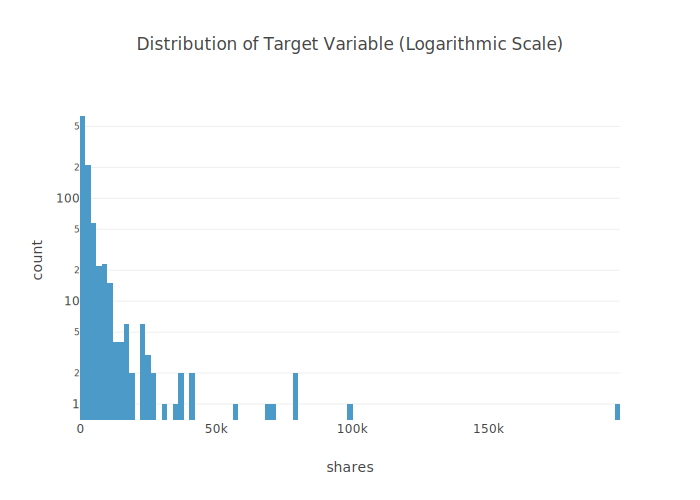

In [45]:
fig = px.histogram(
    data, 
    x='shares', 
    nbins=120, 
    log_y=True, 
    title='Distribution of Target Variable (Logarithmic Scale)'
)
fig.show()

The graph of the target variable's distribution indicates that the disribution is extremely skewed, very few very high values are present which would cause our data to be extremely hard to model. Therefore we need to exclude from the dataset the rows where Y takes extremely high values. In this type of situation it is common to convert the target variable to a logarithmic scale.

Create a dataframe containing the explanatory variables and another one containing only the target variable, which is the number of shares. Convert y to logarithmic scale using np.log10

In [46]:
# Créer le DataFrame pour la variable cible (nombre de partages)
y = dataset_filtered.iloc[:, -1]  # Sélectionne la dernière colonne, 'shares'
y = np.log10(y)       # Convertir 'shares' à l'échelle logarithmique

# Créer le DataFrame pour les variables explicatives (toutes les colonnes sauf la dernière)
X = dataset_filtered.iloc[:, :-1]

# Afficher un aperçu
print("Explanatory variables (X):")
print(X.head())
print("\nTarget variable (y) in logarithmic scale:")
print(y.head())

Explanatory variables (X):
       timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
27187      205.0            12.0            1349.0         0.339059   
2277       693.0            10.0             554.0         0.531760   
18309      369.0            13.0             751.0         0.427793   
15731      428.0            12.0            1207.0         0.478898   
11849      505.0            13.0             329.0         0.616564   

       n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  \
27187                  0.425668       51.0             3.0      33.0   
2277                   0.700880       11.0             7.0       1.0   
18309                  0.578475       12.0             1.0       1.0   
15731                  0.664804       29.0             0.0       1.0   
11849                  0.765000        5.0             2.0       0.0   

       num_videos  average_token_length  ...  avg_positive_polarity  \
27187         1.0              4.851742  .

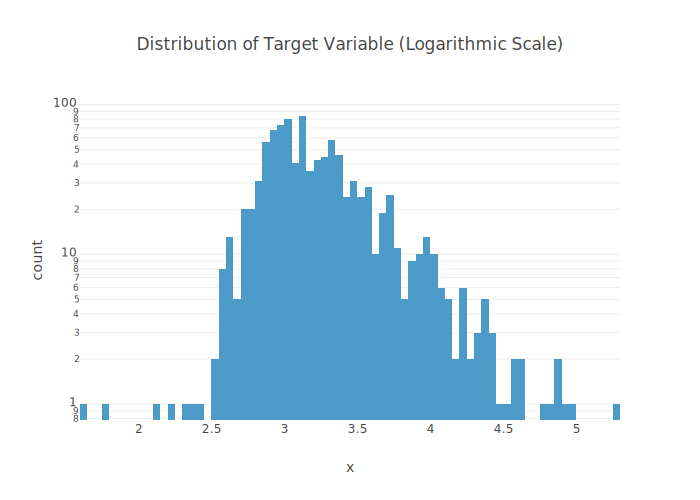

In [47]:
fig = px.histogram(
    data, 
    x=y, 
    nbins=120, 
    log_y=True, 
    title='Distribution of Target Variable (Logarithmic Scale)'
)
fig.show()

In [48]:
X.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
27187,205.0,12.0,1349.0,0.339059,0.425668,51.0,3.0,33.0,1.0,4.851742,...,0.409268,0.050000,1.0,-0.225513,-0.8,-0.076923,0.475000,0.150000,0.025000,0.150000
2277,693.0,10.0,554.0,0.531760,0.700880,11.0,7.0,1.0,0.0,4.722022,...,0.437764,0.033333,1.0,-0.287778,-0.5,-0.155556,0.100000,0.000000,0.400000,0.000000
18309,369.0,13.0,751.0,0.427793,0.578475,12.0,1.0,1.0,0.0,4.482024,...,0.291251,0.050000,0.6,-0.193155,-0.6,-0.050000,0.382143,0.139286,0.117857,0.139286
15731,428.0,12.0,1207.0,0.478898,0.664804,29.0,0.0,1.0,0.0,4.706711,...,0.400437,0.033333,1.0,-0.250309,-0.6,-0.100000,0.500000,0.500000,0.000000,0.500000
11849,505.0,13.0,329.0,0.616564,0.765000,5.0,2.0,0.0,1.0,5.130699,...,0.321488,0.136364,0.5,-0.243333,-0.5,-0.050000,0.000000,0.000000,0.500000,0.000000


Produce a list giving the indices of all couples of variables that are correlated above 90%

In [49]:
# Calculer la matrice de corrélation
corr = X.corr()

# Liste pour stocker les couples de variables ayant une corrélation élevée
high_corr_list = []

# Obtenir les noms des colonnes
cols = corr.columns

# Parcourir chaque colonne pour trouver les corrélations élevées
for j in cols:
    for i, item in corr[j].items():  # Utiliser `items()` au lieu de `iteritems()`
        # Vérifier que l'on ne compare pas une variable avec elle-même (i != j)
        # et que la corrélation est supérieure à 0.9 en valeur absolue
        if (i != j) and abs(item) > 0.9:
            high_corr_list.append((i, j))

# Afficher la liste des couples de variables hautement corrélées
high_corr_list

[('n_non_stop_unique_tokens', 'n_unique_tokens'),
 ('n_unique_tokens', 'n_non_stop_unique_tokens'),
 ('kw_avg_min', 'kw_max_min'),
 ('kw_max_min', 'kw_avg_min'),
 ('self_reference_avg_sharess', 'self_reference_min_shares'),
 ('self_reference_min_shares', 'self_reference_avg_sharess')]

Remove from X all variables that are correlated above 90%. Create an object X_clean that only contains the variables you would like to keep.

In [50]:
# Sélectionner les colonnes à supprimer en prenant une sur deux dans high_corr_list
no_keep = [pair[0] for idx, pair in enumerate(high_corr_list) if idx % 2 == 0]
print("Columns to be dropped:", no_keep)

# Créer une liste des colonnes à garder en excluant celles dans no_keep
columns_to_keep = [col for col in X.columns if col not in no_keep]

# Créer X_clean avec seulement les colonnes à garder
X_clean = X[columns_to_keep]

print('Remaining columns:')
print(X_clean.columns)

Columns to be dropped: ['n_non_stop_unique_tokens', 'kw_avg_min', 'self_reference_avg_sharess']
Remaining columns:
Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares',
       'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_negat

Are the different variables in your dataset on the same scale ? Verify this by using the describe method

In [51]:
# Statistiques descriptives de base pour le dataset
print("Basic statistics: ")
data_desc_cleaned = X_clean.describe(include='all')
display(data_desc_cleaned)
print()

Basic statistics: 


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,350.293000,10.484000,540.058000,0.533191,10.799000,3.19400,4.570000,1.24000,4.567762,7.206000,...,0.359513,0.100505,0.764513,-0.254494,-0.510839,-0.102380,0.277957,0.069438,0.353569,0.152021
std,212.748695,2.092396,465.540633,0.129250,11.115402,3.39085,8.918556,4.55754,0.767052,1.882314,...,0.104204,0.078553,0.239552,0.119911,0.285152,0.083702,0.331816,0.268229,0.185251,0.231603
min,9.000000,5.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,165.000000,9.000000,241.750000,0.473558,4.000000,1.00000,1.000000,0.00000,4.488171,6.000000,...,0.306473,0.050000,0.600000,-0.319729,-0.700000,-0.125000,0.000000,0.000000,0.186458,0.000000
50%,328.500000,10.000000,408.500000,0.538990,7.000000,3.00000,1.000000,0.00000,4.646244,7.000000,...,0.363016,0.100000,0.800000,-0.250000,-0.500000,-0.100000,0.066667,0.000000,0.500000,0.000000
75%,532.000000,12.000000,701.500000,0.610862,13.000000,4.00000,4.000000,1.00000,4.842102,9.000000,...,0.416875,0.100000,1.000000,-0.187500,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000
max,731.000000,17.000000,5530.000000,0.967742,159.000000,34.00000,99.000000,75.00000,5.894330,10.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


Use the train_test_split command from the sklearn.model_selection package to create a training sample containing 70% of the observations and a test sample containing 30% of the observations. Make sure to have used the data you just cleaned.

In [52]:
# Division du dataset en ensembles d'entraînement et de test
print("Dividing dataset into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.3)
print(f"Train set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")
print("...Done.\n")

Dividing dataset into train and test sets...
Train set: 700 samples, Test set: 300 samples
...Done.



 Is it important to normalize data before training a regularized model? If yes normalize your data.

In [53]:
# Normaliser les données d'entraînement et de test avec StandardScaler
scaler = StandardScaler()

# Ajuster le scaler sur les données d'entraînement et transformer
X_train = scaler.fit_transform(X_train)

# Utiliser le même scaler pour transformer les données de test
X_test = scaler.transform(X_test)

Train a non-regularized linear regression model. Are the performances satisfying?

In [54]:
# Entraîner le modèle de régression linéaire
print("Entraînement du modèle...")
regressor = LinearRegression().fit(X_train, y_train)
print("Modèle entraîné.")

# Afficher les scores R^2
train_score = regressor.score(X_train, y_train)
test_score = regressor.score(X_test, y_test)
print(f"R2 score on training set: {train_score:.4f}")
print(f"R2 score on test set: {test_score:.4f}")

Entraînement du modèle...
Modèle entraîné.
R2 score on training set: 0.1945
R2 score on test set: -0.1146


We have R2test << R2train : the model is overfitting!

What could you do to improve the quality of the model?
Overfitting occurs when the model's complexity is to high compared to the number of examples available to train the model. Here, the model's complexity is related to the many features that were included. To reduce complexity, we can either make some feature selection, or use regularization to introduce a constraint on the model's coefficients.

Train a Ridge model by making a grid search to find the optimal value of α. Try values from 0 to 1000 with a step of 10, use a value of 10 as the "cv" parameter and a value of 1 for the "verbose" parameter.


In [57]:
# Définir la plage de valeurs pour alpha
alpha_range = np.arange(0, 1001, 10)

# Configurer la recherche par grille
ridge = Ridge()
param_grid = {'alpha': alpha_range}
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=10, scoring='r2', verbose=1)

# Entraîner le modèle avec la recherche par grille
ridge_grid_search.fit(X_train, y_train)

# Extraire le meilleur modèle et afficher les résultats
best_alpha = ridge_grid_search.best_params_['alpha']
print(f"Meilleure valeur d'alpha: {best_alpha}")

# Extraire le meilleur R2 score
best_score = ridge_grid_search.best_score_
print(f"Meilleure valeur de R2: {best_score}")

Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Meilleure valeur d'alpha: 670
Meilleure valeur de R2: 0.052693938770601946


What is the score on the test set obtained using this optimal alpha parameter?

In [58]:
train_score = ridge_grid_search.score(X_train, y_train)
test_score = ridge_grid_search.score(X_test, y_test)
print(f"R2 score on training set with Ridge: {train_score:.4f}")
print(f"R2 score on test set with Ridge: {test_score:.4f}")

R2 score on training set with Ridge: 0.1472
R2 score on test set with Ridge: -0.0153


Is the test R2 significantly different from the train R2? Use cross-validation to answer.

In [59]:
# 10-fold cross-validation avec modèle Ridge pour évaluer le score R2
print("Performing 10-fold cross-validation with Ridge regression...")
scores = cross_val_score(ridge_grid_search, X_train, y_train, cv=10, scoring='r2')

print(f'The mean cross-validated R2-score is: {scores.mean():.4f}')
print(f'The standard deviation of R2-scores is: {scores.std():.4f}')

Performing 10-fold cross-validation with Ridge regression...
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
Fitting 10 folds for each of 101 candidates, totalling 1010 fits
The mean cross-validated R2-score is: 0.0514
The standard deviation of R2-scores is: 0.0679
